# Dataset downloading

To run the next cell you must have Kaggle CLI installed and your API key put in the right location. Alternatively you can just download the dataset manually from here (https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification)

In [54]:
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification
!unzip is-that-santa-image-classification.zip 
!rm is-that-santa-image-classification.zip 

100%|███████████████████████████████████████▉| 203M/203M [01:32<00:00, 2.89MB/s]
100%|████████████████████████████████████████| 203M/203M [01:32<00:00, 2.31MB/s]
Archive:  is-that-santa-image-classification.zip
  inflating: is that santa/test/not-a-santa/0.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/1.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/100.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/103.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/104.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/105.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/107.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/109.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/110.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/111.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/113.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/114.not-a-santa.jpg  
 

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_image_helper import create_preprocessor

Let's count files in our dataset

In [55]:
for root, dirs, files in os.walk('./is that santa/'):
    if len(files) > 0:
        print(f'{root}: {len(files)} files')

./is that santa/test/santa: 308 files
./is that santa/test/not-a-santa: 308 files
./is that santa/train/santa: 307 files
./is that santa/train/not-a-santa: 307 files


We have 616 files in testing set and 614 files in train set. The former must be split into validation and testing set

In [57]:
!mkdir './is that santa/val'
!mkdir './is that santa/val/santa'
!mkdir './is that santa/val/not-a-santa'

mkdir: cannot create directory ‘./is that santa/val’: File exists


In [58]:
val_santa = random.sample(os.listdir('./is that santa/test/santa'), 154)
val_not_santa = random.sample(os.listdir('./is that santa/test/not-a-santa'), 154)

test_path = os.path.join(os.getcwd(), 'is that santa/test/')
val_path = os.path.join(os.getcwd(), 'is that santa/val/')

for filename in val_santa:
    shutil.move(
        os.path.join(test_path, 'santa', filename),
        os.path.join(val_path, 'santa', filename)
        )
for filename in val_not_santa:
    shutil.move(
        os.path.join(test_path, 'not-a-santa', filename),
        os.path.join(val_path, 'not-a-santa', filename)
        )

Now we will check if files were split correctly

In [59]:
for root, dirs, files in os.walk('./is that santa/'):
    if len(files) > 0:
        print(f'{root}: {len(files)} files')

./is that santa/val/santa: 154 files
./is that santa/val/not-a-santa: 154 files
./is that santa/test/santa: 154 files
./is that santa/test/not-a-santa: 154 files
./is that santa/train/santa: 307 files
./is that santa/train/not-a-santa: 307 files


# Image sets generation and preprocessing

In [60]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './is that santa/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './is that santa/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './is that santa/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 614 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [61]:
train_ds.class_indices

{'not-a-santa': 0, 'santa': 1}

# Basic model training

We will use a pre-trained Xception model

In [76]:
def make_model(learning_rate=0.01):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    outputs = keras.layers.Dense(1, activation='sigmoid')(vectors)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [77]:
model = make_model(learning_rate=0.1)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 2.2874 - accuracy: 0.8371 - val_loss: 1.2727 - val_accuracy: 0.9058
Epoch 2/10
20/20 [==============================] - 30s 2s/step - loss: 0.5606 - accuracy: 0.9479 - val_loss: 0.6156 - val_accuracy: 0.9253
Epoch 3/10
20/20 [==============================] - 30s 1s/step - loss: 0.1309 - accuracy: 0.9756 - val_loss: 0.8332 - val_accuracy: 0.9221
Epoch 4/10
20/20 [==============================] - 30s 2s/step - loss: 0.1715 - accuracy: 0.9658 - val_loss: 0.9753 - val_accuracy: 0.9383
Epoch 5/10
20/20 [==============================] - 31s 2s/step - loss: 0.1268 - accuracy: 0.9756 - val_loss: 1.0072 - val_accuracy: 0.9253
Epoch 6/10
20/20 [==============================] - 31s 2s/step - loss: 0.0492 - accuracy: 0.9870 - val_loss: 0.7797 - val_accuracy: 0.9416
Epoch 7/10
20/20 [==============================] - 29s 1s/step - loss: 0.0427 - accuracy: 0.9886 - val_loss: 0.5448 - val_accuracy: 0.9318
Epoch 8/10
20/20 [==

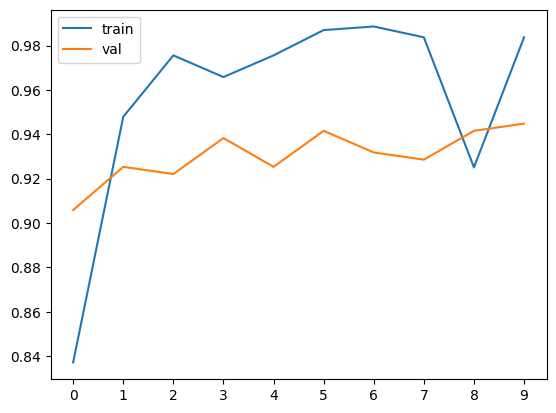

In [78]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

There is clear overfitting as train accuracy reached 0.93 on on the 3th epoch, so let's try a lower learning rate 

In [79]:
model = make_model(learning_rate=0.001)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
20/20 [==============================] - 34s 2s/step - loss: 0.4397 - accuracy: 0.8290 - val_loss: 0.3443 - val_accuracy: 0.8701
Epoch 2/10
20/20 [==============================] - 31s 2s/step - loss: 0.2653 - accuracy: 0.9104 - val_loss: 0.2687 - val_accuracy: 0.8994
Epoch 3/10
20/20 [==============================] - 30s 2s/step - loss: 0.2123 - accuracy: 0.9316 - val_loss: 0.2322 - val_accuracy: 0.9188
Epoch 4/10
20/20 [==============================] - 35s 2s/step - loss: 0.1764 - accuracy: 0.9495 - val_loss: 0.2195 - val_accuracy: 0.9058
Epoch 5/10
20/20 [==============================] - 31s 2s/step - loss: 0.1599 - accuracy: 0.9511 - val_loss: 0.2018 - val_accuracy: 0.9286
Epoch 6/10
20/20 [==============================] - 30s 2s/step - loss: 0.1369 - accuracy: 0.9577 - val_loss: 0.1914 - val_accuracy: 0.9253
Epoch 7/10
20/20 [==============================] - 33s 2s/step - loss: 0.1232 - accuracy: 0.9577 - val_loss: 0.1844 - val_accuracy: 0.9253
Epoch 8/10
20/20 [==

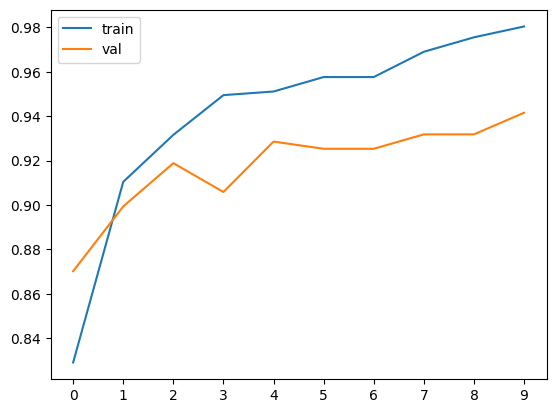

In [80]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

A lot better result and also higher validation accuracy.

# Model performance on the test set

In [81]:
model.evaluate(test_ds)

10/10 [==============================] - 13s 1s/step - loss: 0.1113 - accuracy: 0.9643


[0.11132896691560745, 0.9642857313156128]

We have 96% accuracy on test dataset. Let's check how the model works on an external image

In [49]:
preprocessor = create_preprocessor('xception', (150, 150))

In [88]:
!wget https://cdn.hswstatic.com/gif/santa-claus-orig.jpg

--2022-12-17 12:45:18--  https://cdn.hswstatic.com/gif/santa-claus-orig.jpg
Resolving cdn.hswstatic.com (cdn.hswstatic.com)... 99.84.88.60, 99.84.88.115, 99.84.88.101, ...
Connecting to cdn.hswstatic.com (cdn.hswstatic.com)|99.84.88.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495306 (484K) [image/jpeg]
Saving to: ‘santa-claus-orig.jpg’

santa-claus-orig.jp 100%[===================>] 483.70K  1.16MB/s    in 0.4s    

2022-12-17 12:45:19 (1.16 MB/s) - ‘santa-claus-orig.jpg’ saved [495306/495306]



In [89]:
path = './'
name = 'santa-claus-orig.jpg'
fullname = path + '/' + name
img = load_img(fullname, target_size=(150, 150))
X = preprocess_input(np.array([np.array(img)]))
pred = model.predict(X)
pred

1/1 [==============================] - 0s 159ms/step


array([[0.9957939]], dtype=float32)

# Model saving

In [90]:
model.save('santa-class-v1.h5')

In [91]:
tf.saved_model.save(model, 'santa-class-v1')

INFO:tensorflow:Assets written to: santa-class-v1/assets


INFO:tensorflow:Assets written to: santa-class-v1/assets
